In [1]:
import sys

sys.path.append("../src/")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pgmpy.estimators import PC
from pgmpy.models import BayesianNetwork

from utils import compute_evaluation_metrics

In [3]:
covid_policies_df = pd.read_csv(
    "../data/processed/Final_Data_Combined.csv", index_col=0
)
print(covid_policies_df.shape)
covid_policies_df.head()

(11993, 19)


,Country,Date,school_closures,workplace_closures,cancel_public_events,restrict_public_gathering,closure_public_transport,SHN_requirement,restriction_internal_movement,internation_travel_control,PI_Campaign,testing_policy,contact_tracing,Facial_Covering,Vaccine_policy,income_support,debt_relief,Confirmed_cases,Confirmed_Deathes
0,Argentina,2020-05-02,3G,3T,2G,4G,2G,2G,1G,4.0,2G,1.0,2.0,3G,0,1A,2.0,4681.0,237.0
1,Argentina,2020-05-03,3G,3T,2G,4G,2G,2G,1G,4.0,2G,1.0,2.0,3G,0,1A,2.0,4783.0,246.0
2,Argentina,2020-05-04,3G,3T,2G,4G,2G,2G,1G,4.0,2G,1.0,2.0,3G,0,1A,2.0,4887.0,260.0
3,Argentina,2020-05-05,3G,3T,2G,4G,2G,2G,1G,4.0,2G,1.0,2.0,3G,0,1A,2.0,5020.0,264.0
4,Argentina,2020-05-06,3G,3T,2G,4G,2G,2G,1G,4.0,2G,1.0,2.0,3G,0,1A,2.0,5208.0,273.0


## Preprocessing

In [4]:
covid_policies_df["date"] = pd.to_datetime(covid_policies_df["Date"])
covid_policies_df["Country"] = covid_policies_df["Country"].str.lower()
covid_policies_df["Country"] = covid_policies_df["Country"].str.replace(" ", "_")
covid_policies_df.rename(columns={"Country": "country"}, inplace=True)
covid_policies_df.set_index(["country", "date"], inplace=True)
covid_policies_df.drop(columns=["Date"], inplace=True)
covid_policies_df.rename(
    columns={col: col.lower() for col in covid_policies_df.columns}, inplace=True
)
print(covid_policies_df.shape)
covid_policies_df.head()

(11993, 17)


school_closures workplace_closures cancel_public_events  \
country   date                                                                 
argentina 2020-05-02              3G                 3T                   2G   
          2020-05-03              3G                 3T                   2G   
          2020-05-04              3G                 3T                   2G   
          2020-05-05              3G                 3T                   2G   
          2020-05-06              3G                 3T                   2G   

                     restrict_public_gathering closure_public_transport  \
country   date                                                            
argentina 2020-05-02                        4G                       2G   
          2020-05-03                        4G                       2G   
          2020-05-04                        4G                       2G   
          2020-05-05                        4G                       2G   
          2020-05-06                        4G                       2G   

                     shn_requirement restriction_internal_movement  \
country   date                                                       
argentina 2020-05-02              2G                            1G   
          2020-05-03              2G                            1G   
          2020-05-04              2G                            1G   
          2020-05-05              2G                            1G   
          2020-05-06              2G                            1G   

                      internation_travel_control pi_campaign  testing_policy  \
country   date                                                                 
argentina 2020-05-02                         4.0          2G             1.0   
          2020-05-03                         4.0          2G             1.0   
          2020-05-04                         4.0          2G             1.0   
          2020-05-05                         4.0          2G             1.0   
          2020-05-06                         4.0          2G             1.0   

                      contact_tracing facial_covering vaccine_policy  \
country   date                                                         
argentina 2020-05-02              2.0              3G              0   
          2020-05-03              2.0              3G              0   
          2020-05-04              2.0              3G              0   
          2020-05-05              2.0              3G              0   
          2020-05-06              2.0              3G              0   

                     income_support  debt_relief  confirmed_cases  \
country   date                                                      
argentina 2020-05-02             1A          2.0           4681.0   
          2020-05-03             1A          2.0           4783.0   
          2020-05-04             1A          2.0           4887.0   
          2020-05-05             1A          2.0           5020.0   
          2020-05-06             1A          2.0           5208.0   

                      confirmed_deathes  
country   date                           
argentina 2020-05-02              237.0  
          2020-05-03              246.0  
          2020-05-04              260.0  
          2020-05-05              264.0  
          2020-05-06              273.0

In [5]:
for column in covid_policies_df.columns:
    print(column, covid_policies_df[column].unique())

school_closures ['3G' '3T' '1G' '2T' '0' '1T' '2G']
workplace_closures ['3T' '2T' '2G' '1G' '1T' '0' '3G']
cancel_public_events ['2G' '2T' '1G' '1T' '0']
restrict_public_gathering ['4G' '4T' '3G' '1G' '3T' '2T' '2G' '0']
closure_public_transport ['2G' '2T' '1G' '0' '1T']
shn_requirement ['2G' '2T' '1T' '1G' '0' '3T' '3G']
restriction_internal_movement ['1G' '2G' '2T' '1T' '0']
internation_travel_control [4. 3. 2. 1. 0.]
pi_campaign ['2G' '2T' '0']
testing_policy [1. 2. 3.]
contact_tracing [2. 1. 0.]
facial_covering ['3G' '2G' '4G' '0' '1T' '4T' '2T' '3T' '1G']
vaccine_policy ['0' '1G' '2G' '3G' '4G' '5G']
income_support ['1A' '0' '2A' '1F' '2F']
debt_relief [2. 1. 0.]
confirmed_cases [   4681.    4783.    4887. ... 3669671. 3671991. 3673257.]
confirmed_deathes [  237.   246.   260. ... 99145. 99191. 99229.]


In [6]:
for column in covid_policies_df.columns:
    if pd.api.types.is_numeric_dtype(covid_policies_df[column].dtype):
        continue

    covid_policies_df[column] = (
        covid_policies_df[column].apply(lambda v: v[:1]).astype("int16")
    )

display(covid_policies_df.info())
covid_policies_df.head()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11993 entries, ('argentina', Timestamp('2020-05-02 00:00:00')) to ('south_africa', Timestamp('2022-02-27 00:00:00'))
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   school_closures                11993 non-null  int16  
 1   workplace_closures             11993 non-null  int16  
 2   cancel_public_events           11993 non-null  int16  
 3   restrict_public_gathering      11993 non-null  int16  
 4   closure_public_transport       11993 non-null  int16  
 5   shn_requirement                11993 non-null  int16  
 6   restriction_internal_movement  11993 non-null  int16  
 7   internation_travel_control     11993 non-null  float64
 8   pi_campaign                    11993 non-null  int16  
 9   testing_policy                 11993 non-null  float64
 10  contact_tracing                11993 non-null  float64
 11  facial_covering

None

school_closures  workplace_closures  \
country   date                                              
argentina 2020-05-02                3                   3   
          2020-05-03                3                   3   
          2020-05-04                3                   3   
          2020-05-05                3                   3   
          2020-05-06                3                   3   

                      cancel_public_events  restrict_public_gathering  \
country   date                                                          
argentina 2020-05-02                     2                          4   
          2020-05-03                     2                          4   
          2020-05-04                     2                          4   
          2020-05-05                     2                          4   
          2020-05-06                     2                          4   

                      closure_public_transport  shn_requirement  \
country   date                                                    
argentina 2020-05-02                         2                2   
          2020-05-03                         2                2   
          2020-05-04                         2                2   
          2020-05-05                         2                2   
          2020-05-06                         2                2   

                      restriction_internal_movement  \
country   date                                        
argentina 2020-05-02                              1   
          2020-05-03                              1   
          2020-05-04                              1   
          2020-05-05                              1   
          2020-05-06                              1   

                      internation_travel_control  pi_campaign  testing_policy  \
country   date                                                                  
argentina 2020-05-02                         4.0            2             1.0   
          2020-05-03                         4.0            2             1.0   
          2020-05-04                         4.0            2             1.0   
          2020-05-05                         4.0            2             1.0   
          2020-05-06                         4.0            2             1.0   

                      contact_tracing  facial_covering  vaccine_policy  \
country   date                                                           
argentina 2020-05-02              2.0                3               0   
          2020-05-03              2.0                3               0   
          2020-05-04              2.0                3               0   
          2020-05-05              2.0                3               0   
          2020-05-06              2.0                3               0   

                      income_support  debt_relief  confirmed_cases  \
country   date                                                       
argentina 2020-05-02               1          2.0           4681.0   
          2020-05-03               1          2.0           4783.0   
          2020-05-04               1          2.0           4887.0   
          2020-05-05               1          2.0           5020.0   
          2020-05-06               1          2.0           5208.0   

                      confirmed_deathes  
country   date                           
argentina 2020-05-02              237.0  
          2020-05-03              246.0  
          2020-05-04              260.0  
          2020-05-05              264.0  
          2020-05-06              273.0

## Add Features

In [7]:
country_to_population_map = {  # for 2021
    "argentina": 45.85e6,
    "australia": 25750198,
    "brazil": 212.61e6,
    "canada": 37.74e6,
    "switzerland": 8.66e6,
    "germany": 83900473,
    "egypt": 101.48e6,
    "finland": 5.54e6,
    "india": 1.39e9,
    "united_states": 332915073,
    "new_zealand": 5122600,
    "south_africa": 60e6,
    "hong_kong": 7500000,
    "china": 1448000000,
    "indonesia": 272000000,
    "singapore": 5450000,
    "malaysia": 32000000,
    "israel": 9.45e6,
}

In [8]:
def compute_cases_bin(cases_per_mil):
    computed_bin = None
    if cases_per_mil <= 10000:
        computed_bin = 0
    elif cases_per_mil < 30000:
        computed_bin = 1
    elif cases_per_mil < 50000:
        computed_bin = 2
    elif cases_per_mil < 70000:
        computed_bin = 3
    elif cases_per_mil < 100000:
        computed_bin = 4
    elif cases_per_mil < 120000:
        computed_bin = 5
    else:
        computed_bin = 6

    return computed_bin


covid_policies_df["cases_per_mil"] = covid_policies_df.apply(
    lambda row: (row.confirmed_cases * 1000000)
    / country_to_population_map[row.name[0]],
    axis=1,
)
covid_policies_df["cases_per_mil_cat"] = covid_policies_df["cases_per_mil"].apply(
    compute_cases_bin
)
print(covid_policies_df.shape)
covid_policies_df.head()

(11993, 19)


school_closures  workplace_closures  \
country   date                                              
argentina 2020-05-02                3                   3   
          2020-05-03                3                   3   
          2020-05-04                3                   3   
          2020-05-05                3                   3   
          2020-05-06                3                   3   

                      cancel_public_events  restrict_public_gathering  \
country   date                                                          
argentina 2020-05-02                     2                          4   
          2020-05-03                     2                          4   
          2020-05-04                     2                          4   
          2020-05-05                     2                          4   
          2020-05-06                     2                          4   

                      closure_public_transport  shn_requirement  \
country   date                                                    
argentina 2020-05-02                         2                2   
          2020-05-03                         2                2   
          2020-05-04                         2                2   
          2020-05-05                         2                2   
          2020-05-06                         2                2   

                      restriction_internal_movement  \
country   date                                        
argentina 2020-05-02                              1   
          2020-05-03                              1   
          2020-05-04                              1   
          2020-05-05                              1   
          2020-05-06                              1   

                      internation_travel_control  pi_campaign  testing_policy  \
country   date                                                                  
argentina 2020-05-02                         4.0            2             1.0   
          2020-05-03                         4.0            2             1.0   
          2020-05-04                         4.0            2             1.0   
          2020-05-05                         4.0            2             1.0   
          2020-05-06                         4.0            2             1.0   

                      contact_tracing  facial_covering  vaccine_policy  \
country   date                                                           
argentina 2020-05-02              2.0                3               0   
          2020-05-03              2.0                3               0   
          2020-05-04              2.0                3               0   
          2020-05-05              2.0                3               0   
          2020-05-06              2.0                3               0   

                      income_support  debt_relief  confirmed_cases  \
country   date                                                       
argentina 2020-05-02               1          2.0           4681.0   
          2020-05-03               1          2.0           4783.0   
          2020-05-04               1          2.0           4887.0   
          2020-05-05               1          2.0           5020.0   
          2020-05-06               1          2.0           5208.0   

                      confirmed_deathes  cases_per_mil  cases_per_mil_cat  
country   date                                                             
argentina 2020-05-02              237.0     102.093784                  0  
          2020-05-03              246.0     104.318430                  0  
          2020-05-04              260.0     106.586696                  0  
          2020-05-05              264.0     109.487459                  0  
          2020-05-06              273.0     113.587786                  0

In [9]:
# covid_policies_df.to_csv("../data/processed/categorical_policies.csv")

In [10]:
sg_filtered = covid_policies_df.loc[
    "singapore",
    [
        "school_closures",
        "workplace_closures",
        #         "cancel_public_events",
        #         "restrict_public_gathering",
        #         "closure_public_transport",
        "cases_per_mil",
        "cases_per_mil_cat",
        "confirmed_cases",
    ],
]
sg_filtered.head()

,school_closures,workplace_closures,cases_per_mil,cases_per_mil_cat,confirmed_cases
date,,,,,
2020-05-02,3,3,3219.816514,0,17548.0
2020-05-03,3,3,3340.366972,0,18205.0
2020-05-04,3,3,3445.504587,0,18778.0
2020-05-05,3,3,3561.467890,0,19410.0
2020-05-06,3,3,3706.055046,0,20198.0


In [11]:
ml_filtered = covid_policies_df.loc[
    "malaysia",
    [
        "school_closures",
        "workplace_closures",
        #         "cancel_public_events",
        #         "restrict_public_gathering",
        #         "closure_public_transport",
        "cases_per_mil",
        "cases_per_mil_cat",
        "confirmed_cases",
    ],
]

ml_filtered.head()

,school_closures,workplace_closures,cases_per_mil,cases_per_mil_cat,confirmed_cases
date,,,,,
2020-05-02,3,3,193.00000,0,6176.0
2020-05-03,3,3,196.81250,0,6298.0
2020-05-04,3,2,198.53125,0,6353.0
2020-05-05,3,2,199.46875,0,6383.0
2020-05-06,3,2,200.87500,0,6428.0


<AxesSubplot:xlabel='cases_per_mil', ylabel='Count'>

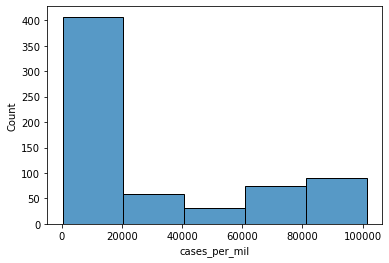

In [12]:
import seaborn as sns

sns.histplot(ml_filtered.cases_per_mil, bins=5)

In [13]:
# from pgmpy.estimators import PC

# est = PC(data=sg_filtered[["school_closures", "workplace_closures", "cases_per_mil_cat"]].iloc[:500], )
# res = est.estimate(max_cond_vars=3)
# import networkx as nx

# nx.draw(res, with_labels=True)

## Contruct DGM with a subset of features

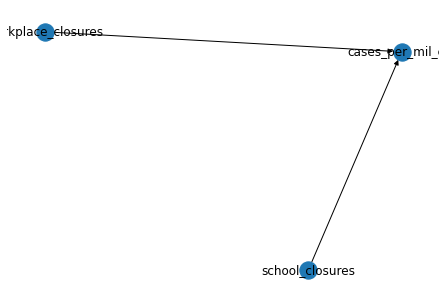

In [14]:
import networkx as nx
from pgmpy.models import BayesianNetwork

sample_model = BayesianNetwork(
    [
        ("school_closures", "cases_per_mil_cat"),
        ("workplace_closures", "cases_per_mil_cat"),
    ]
)
nx.draw(sample_model, with_labels=True)

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    ml_filtered[["school_closures", "workplace_closures"]],
    ml_filtered[["cases_per_mil_cat"]],
    random_state=111,
)
x_train.shape, x_test.shape

((495, 2), (166, 2))

In [16]:
y_train.cases_per_mil_cat.value_counts()

0    241
4    101
1     97
3     29
2     25
5      2
Name: cases_per_mil_cat, dtype: int64

In [17]:
y_test.cases_per_mil_cat.value_counts()

0    73
4    42
1    35
2     9
3     7
Name: cases_per_mil_cat, dtype: int64

In [18]:
from pgmpy.estimators import MaximumLikelihoodEstimator

sample_model.fit(pd.concat([x_train, y_train], axis=1), MaximumLikelihoodEstimator)

In [19]:
for cpd in sample_model.get_cpds():
    print(cpd)

+--------------------+-----------+
| school_closures(0) | 0.0626263 |
+--------------------+-----------+
| school_closures(1) | 0.0606061 |
+--------------------+-----------+
| school_closures(2) | 0.339394  |
+--------------------+-----------+
| school_closures(3) | 0.537374  |
+--------------------+-----------+
+----------------------+-----+-----------------------+
| school_closures      | ... | school_closures(3)    |
+----------------------+-----+-----------------------+
| workplace_closures   | ... | workplace_closures(3) |
+----------------------+-----+-----------------------+
| cases_per_mil_cat(0) | ... | 0.8068181818181818    |
+----------------------+-----+-----------------------+
| cases_per_mil_cat(1) | ... | 0.011363636363636364  |
+----------------------+-----+-----------------------+
| cases_per_mil_cat(2) | ... | 0.18181818181818182   |
+----------------------+-----+-----------------------+
| cases_per_mil_cat(3) | ... | 0.0                   |
+----------------------+-

In [20]:
from pgmpy.inference import VariableElimination

ve = VariableElimination(sample_model)

print(
    ve.query(
        ["cases_per_mil_cat"], evidence={"school_closures": 2, "workplace_closures": 1}
    )
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+----------------------+--------------------------+
| cases_per_mil_cat    |   phi(cases_per_mil_cat) |
+======================+==========================+
| cases_per_mil_cat(0) |                   0.0000 |
+----------------------+--------------------------+
| cases_per_mil_cat(1) |                   0.0000 |
+----------------------+--------------------------+
| cases_per_mil_cat(2) |                   0.0000 |
+----------------------+--------------------------+
| cases_per_mil_cat(3) |                   0.0526 |
+----------------------+--------------------------+
| cases_per_mil_cat(4) |                   0.9474 |
+----------------------+--------------------------+
| cases_per_mil_cat(5) |                   0.0000 |
+----------------------+--------------------------+


### Test

In [21]:
pred_test_y = []
for _, row in x_test.iterrows():
    pred = ve.query(
        ["cases_per_mil_cat"],
        evidence={
            "school_closures": row["school_closures"],
            "workplace_closures": row["workplace_closures"],
        },
        show_progress=False,
    )
    pred_test_y.append(pred.values.argmax())

In [22]:
y_test.cases_per_mil_cat.unique()

array([4, 1, 3, 0, 2])

In [23]:
pd.DataFrame(pred_test_y)[0].unique()

array([4, 1, 0])

In [25]:
compute_evaluation_metrics(y_test.cases_per_mil_cat.values, pred_test_y)

{'accuracy': 0.7289156626506024,
 'f1': 0.6804281642699832,
 'recall': 0.7289156626506024}

## Influence of Singapore's policies on Malaysia's policies

In [26]:
two_country_df = covid_policies_df.reset_index()
two_country_df = two_country_df[two_country_df.country.isin(["malaysia", "singapore"])]
two_country_df = two_country_df.reset_index(drop=True)
two_country_df = two_country_df[
    ["country", "date", "school_closures", "workplace_closures"]
].copy()
transformed_dfs = []
for country in two_country_df.country.unique():
    filter_df = two_country_df[two_country_df.country == country].copy()
    filter_df.rename(
        columns={
            col: country + "_" + col
            for col in ["school_closures", "workplace_closures"]
        },
        inplace=True,
    )
    filter_df.drop(["country"], axis=1, inplace=True)
    transformed_dfs.append(filter_df)

In [27]:
merged_df = pd.merge(transformed_dfs[0], transformed_dfs[1], on=["date"])
merged_df.set_index(["date"], inplace=True)
merged_df

,malaysia_school_closures,malaysia_workplace_closures,singapore_school_closures,singapore_workplace_closures
date,,,,
2020-05-02,3,3,3,3
2020-05-03,3,3,3,3
2020-05-04,3,2,3,3
2020-05-05,3,2,3,3
2020-05-06,3,2,3,3
...,...,...,...,...
2022-02-17,2,2,1,3
2022-02-18,2,2,1,3
2022-02-19,2,2,1,3


In [28]:
x_train, x_test, y_train, y_test = train_test_split(
    merged_df[["malaysia_school_closures", "singapore_school_closures"]],
    merged_df[["malaysia_workplace_closures", "singapore_workplace_closures"]],
)
x_train.shape, x_test.shape

((495, 2), (166, 2))

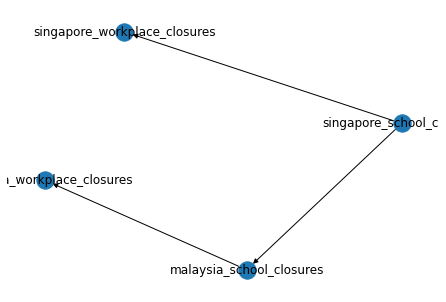

In [29]:
# 2 country model for economic policy effect analysis
two_country_model = BayesianNetwork(
    [
        ("singapore_school_closures", "malaysia_school_closures"),
        ("singapore_school_closures", "singapore_workplace_closures"),
        ("malaysia_school_closures", "malaysia_workplace_closures"),
    ]
)
two_country_model.fit(pd.concat([x_train, y_train], axis=1), MaximumLikelihoodEstimator)
nx.draw(two_country_model, with_labels=True)

In [30]:
for cpd in two_country_model.get_cpds():
    print(cpd)

+------------------------------+-----------+
| singapore_school_closures(1) | 0.816162  |
+------------------------------+-----------+
| singapore_school_closures(2) | 0.0666667 |
+------------------------------+-----------+
| singapore_school_closures(3) | 0.117172  |
+------------------------------+-----------+
+-----------------------------+-----+------------------------------+
| singapore_school_closures   | ... | singapore_school_closures(3) |
+-----------------------------+-----+------------------------------+
| malaysia_school_closures(0) | ... | 0.29310344827586204          |
+-----------------------------+-----+------------------------------+
| malaysia_school_closures(1) | ... | 0.0                          |
+-----------------------------+-----+------------------------------+
| malaysia_school_closures(2) | ... | 0.0                          |
+-----------------------------+-----+------------------------------+
| malaysia_school_closures(3) | ... | 0.7068965517241379        

In [32]:
from pgmpy.inference import VariableElimination

ve = VariableElimination(two_country_model)

print(
    ve.query(["malaysia_workplace_closures"], evidence={"malaysia_school_closures": 2})
)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

+--------------------------------+------------------------------------+
| malaysia_workplace_closures    |   phi(malaysia_workplace_closures) |
+================================+====================================+
| malaysia_workplace_closures(1) |                             0.4576 |
+--------------------------------+------------------------------------+
| malaysia_workplace_closures(2) |                             0.2316 |
+--------------------------------+------------------------------------+
| malaysia_workplace_closures(3) |                             0.3107 |
+--------------------------------+------------------------------------+
